In [1]:
import sys

sys.path.append('../../../MembraneQuant')
from membranequant import *
import seaborn as sns
import scipy.odr as odr
from scipy.optimize import curve_fit
import sympy as sp
import scipy.stats as st

%matplotlib notebook

### Full data

In [102]:
df = pd.read_csv('../res1_df.csv')

### Normalise

In [3]:
x_wt_full = np.mean(df[(df.Line == 'nwg201') & (df.Condition == 'wt')].Cyt.to_numpy())
y_wt_full = np.mean(df[(df.Line == 'nwg201') & (df.Condition == 'wt')].Mem_tot.to_numpy())
# print(x_wt_full)
# print(y_wt_full)
# print(y_wt_full / x_wt_full)

In [4]:
x_wt = df[df.Line == 'nwg201'].Cyt.to_numpy() / x_wt_full
y_wt = df[df.Line == 'nwg201'].Mem_tot.to_numpy() / y_wt_full
x_l109r = df[df.Line == 'nwg369'].Cyt.to_numpy() / x_wt_full
y_l109r = df[df.Line == 'nwg369'].Mem_tot.to_numpy() / y_wt_full

### Conversion factors

In [5]:
a = 0.01 # thickness of cortical compartment in um
b = 1e-8  # molar concentration of wild type cytoplasm
c = 2.8893596260583494  # conversion factor for membrane concentrations

xc = b
xm = c * (y_wt_full / x_wt_full) * (1 / a) * b

### Data for fitting

In [6]:
cyts1 = np.r_[x_wt, x_l109r * 0]
cyts2 = np.r_[x_wt * 0, x_l109r]
cyts = np.c_[cyts1, cyts2]
mems = np.r_[y_wt, y_l109r]

### Functions

In [7]:
def fitting(model, cyts, mems):
    # Ols fit
    popt, pcov = curve_fit(model, cyts.T, mems)
    params_0 = popt

    # Odr fit
    def perform_odr(x, y):
        quadr = odr.Model(lambda B, x: model(x, *B))
        mydata = odr.Data(x, y)
        myodr = odr.ODR(mydata, quadr, beta0=params_0)
        output = myodr.run()
        return output

    regression = perform_odr(cyts.T, mems)
    params = regression.beta
            
    return params

def bootstrap_fitting(model, c1, c2, m1, m2, n):
    params = []
    for i in range(n):  
        inds1 = np.random.choice(range(len(c1)), len(c1))
        inds2 = np.random.choice(range(len(c2)), len(c2))
        _c1 = c1[inds1]
        _c2 = c2[inds2]
        
        cyts1 = np.r_[_c1, _c2 * 0]
        cyts2 = np.r_[_c1 * 0, _c2]
        cyts = np.c_[cyts1, cyts2]
        mems = np.r_[m1[inds1], m2[inds2]]
                    
        try:
            _p = fitting(model, cyts, mems)
            if np.sum(_p < 0) == 0:
                params.append(_p)
        except:
            pass
        
    return params

def confidence_interval(model, cyts, mems, params, interval=95, n_x=100): 
    x1 = np.linspace(0, np.max(cyts[:, 0]), n_x)
    x2 = np.linspace(0, np.max(cyts[:, 1]), n_x)
    all_fits = np.zeros([n_x, len(params)])
    for i, (_x1, _x2) in enumerate(zip(x1, x2)):
        for j, p in enumerate(params):
            all_fits[i, j] = model([_x1, _x2], *p)
    
    all_fits_lower = np.percentile(all_fits, (100 - interval) / 2, axis=1)
    all_fits_upper = np.percentile(all_fits, 50 + (interval / 2), axis=1)
    return [x1, x2, all_fits_lower, all_fits_upper]

In [8]:
def model(cyt, ka1, ka2, km):
    c1 = cyt[0] * xc # convert cytoplasmic concentrations to real units
    m1 = c1 * km * (c1 * ka1 * km * (2 * c1 * ka1 + np.sqrt(4 * c1 * ka1 + 1) + 1) + np.sqrt(
        4 * c1 ** 3 * ka1 ** 3 + 6 * c1 ** 2 * ka1 ** 2 * np.sqrt(
            4 * c1 * ka1 + 1) + 18 * c1 ** 2 * ka1 ** 2 + 8 * c1 * ka1 * np.sqrt(
            4 * c1 * ka1 + 1) + 12 * c1 * ka1 + 2 * np.sqrt(4 * c1 * ka1 + 1) + 2)) / (
                2 * c1 ** 2 * ka1 ** 2 + 2 * c1 * ka1 * np.sqrt(4 * c1 * ka1 + 1) + 4 * c1 * ka1 + np.sqrt(4 * c1 * ka1 + 1) + 1)
    
    c2 = cyt[1] * xc
    m2 = c2 * km * (c2 * ka2 * km * (2 * c2 * ka2 + np.sqrt(4 * c2 * ka2 + 1) + 1) + np.sqrt(
        4 * c2 ** 3 * ka2 ** 3 + 6 * c2 ** 2 * ka2 ** 2 * np.sqrt(
            4 * c2 * ka2 + 1) + 18 * c2 ** 2 * ka2 ** 2 + 8 * c2 * ka2 * np.sqrt(
            4 * c2 * ka2 + 1) + 12 * c2 * ka2 + 2 * np.sqrt(4 * c2 * ka2 + 1) + 2)) / (
                2 * c2 ** 2 * ka2 ** 2 + 2 * c2 * ka2 * np.sqrt(4 * c2 * ka2 + 1) + 4 * c2 * ka2 + np.sqrt(4 * c2 * ka2 + 1) + 1)
    
    # at this point membrane concentrations are in real units - need to convert back to normalised units
    return m1 / xm + m2 / xm

### Fitting

In [9]:
p = fitting(model, cyts, mems)
p_log = np.log(p)

### Bootstrapping

In [10]:
pb = bootstrap_fitting(model, x_wt, x_l109r, y_wt, y_l109r, n=10000)
print(len(pb))
pb_log = np.log(np.array(pb))

9999


### 2D plot with histograms

<IPython.core.display.Javascript object>


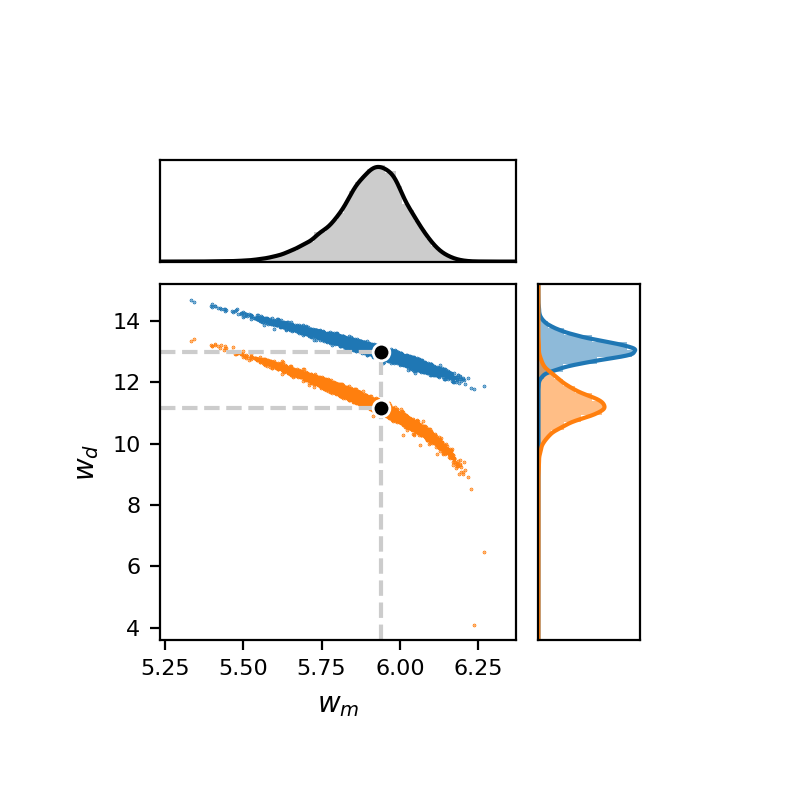

In [11]:
def parameter_bootstrap_plot(p, p_bootstrap):

    # Initiate figure
    fig = plt.figure(figsize=(4, 4))
    gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                          left=0.2, right=0.8, bottom=0.2, top=0.8,
                          wspace=0.1, hspace=0.1)
    ax = fig.add_subplot(gs[1, 0])
    ax_histx = fig.add_subplot(gs[0, 0])
    ax_histy = fig.add_subplot(gs[1, 1])

    # Axis limits (auto)
    xmin = np.min(p_bootstrap[:, 2]) - 0.1
    xmax = np.max(p_bootstrap[:, 2]) + 0.1
    ymin = min(np.min(p_bootstrap[:, 0]), np.min(p_bootstrap[:, 1])) - 0.5
    ymax = max(np.max(p_bootstrap[:, 0]), np.max(p_bootstrap[:, 1])) + 0.5
    nbins = 50
    
    # Scatter - all data
    ax.scatter(p_bootstrap[:, 2], p_bootstrap[:, 0], c='tab:blue', s=0.1)
    ax.scatter(p_bootstrap[:, 2], p_bootstrap[:, 1], c='tab:orange', s=0.1)  
    ax.set_xlabel(r'$w_m$')
    ax.set_ylabel(r'$w_d$')
    ax.tick_params(axis='both', labelsize=8)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    # Scatter - best fit parameters
    ax.plot([xmin, p[2]], [p[0], p[0]], c='0.8', linestyle='--')
    ax.plot([xmin, p[2]], [p[1], p[1]], c='0.8', linestyle='--')
    ax.plot([p[2], p[2]], [ymin, p[0]], c='0.8', linestyle='--')
    ax.scatter(p[2], p[0], c='k', edgecolors='w', zorder=10)
    ax.scatter(p[2], p[1], c='k', edgecolors='w', zorder=10)

    # wm histogram
    kde = st.gaussian_kde(p_bootstrap[:, 2])
    xx = np.linspace(xmin, xmax, 1000)
    ax_histx.plot(xx, kde(xx), c='k')
    ax_histx.hist(p_bootstrap[:, 2], bins=nbins, alpha=0.2, color='k', density=True)
    ax_histx.tick_params(axis='both', labelsize=8)
    ax_histx.set_xlim(xmin, xmax)
    ax_histx.set_xticks([])
    ax_histx.set_yticks([])

    # wd histogram
    xx = np.linspace(ymin, ymax, 1000)
    kde = st.gaussian_kde(p_bootstrap[:, 0])
    ax_histy.plot(kde(xx), xx, c='tab:blue')
    kde = st.gaussian_kde(p_bootstrap[:, 1])
    ax_histy.plot(kde(xx), xx, c='tab:orange')
    ax_histy.hist(p_bootstrap[:, 0], bins=np.linspace(ymin, ymax, nbins), alpha=0.5, density=True, 
                  orientation='horizontal')
    ax_histy.hist(p_bootstrap[:, 1], bins=np.linspace(ymin, ymax, nbins), alpha=0.5, density=True, 
                  orientation='horizontal')
    ax_histy.tick_params(axis='both', labelsize=8)
    ax_histy.set_ylim(ymin, ymax)
    ax_histy.set_xticks([])
    ax_histy.set_yticks([])
    fig.savefig('Figs/parameters_bootstrap.png', dpi=600, transparent=True)
    
parameter_bootstrap_plot(p_log, pb_log)

### Model vs data

In [12]:
ci_wt = confidence_interval(model, np.c_[x_wt, np.zeros(len(x_wt))], y_wt, pb, interval=95, n_x=100)
ci_l109r = confidence_interval(model, np.c_[np.zeros(len(x_l109r)), x_l109r], y_l109r, pb, interval=95, n_x=100)

In [13]:
def model_vs_data_fig(ax, norm_units=False, xmin=None, xmax=None, ymin=None, ymax=None):
    if norm_units:
        norm_x = 1
        norm_y = 1
    else:
        norm_x = xc
        norm_y = xm
    
    # Wild type model fit
    x_model_norm = np.c_[np.linspace(0, max(x_wt), 100), np.zeros(100)]
    y_model_norm = model(x_model_norm.T, *p)
    x_ci_norm, y1_ci_norm, y2_ci_norm = ci_wt[0], ci_wt[2], ci_wt[3]
    ax.plot(x_model_norm[:, 0] * norm_x, y_model_norm * norm_y, c='tab:blue', zorder=0)
    ax.fill_between(x_ci_norm * norm_x, y1_ci_norm * norm_y, y2_ci_norm * norm_y, alpha=0.1, color='tab:blue')

    # L109R model fit
    x_model_norm = np.c_[np.zeros(100), np.linspace(0, max(x_l109r), 100)]
    y_model_norm = model(x_model_norm.T, *p)
    x_ci_norm, y1_ci_norm, y2_ci_norm = ci_l109r[1], ci_l109r[2], ci_l109r[3]
    ax.plot(x_model_norm[:, 1] * norm_x, y_model_norm * norm_y, c='tab:orange', zorder=0)
    ax.fill_between(x_ci_norm * norm_x, y1_ci_norm * norm_y, y2_ci_norm * norm_y, alpha=0.1, color='tab:orange')

    # Data
    ax.scatter(x_wt * norm_x, y_wt * norm_y, c='tab:blue', edgecolors='k', s=20)
    ax.scatter(x_l109r * norm_x, y_l109r * norm_y, c='tab:orange', edgecolors='k', s=20)

    # Finalise plot
    ax.set_xlabel('Cytoplasmic concentration')
    ax.set_ylabel('Membrane concentration')
    ax.tick_params(axis='both', labelsize=8)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    return ax

### Dimeric state

In [14]:
def monomer_fraction(conc, wd):
    return ((np.sqrt(4*conc*np.exp(wd) + 1) - 1)*np.exp(-wd)/2) / conc

def dimer_fraction(conc, wd):
    return 1 - (((np.sqrt(4*conc*np.exp(wd) + 1) - 1)*np.exp(-wd)/2) / conc)

In [15]:
def dimer_fig(ax, data_wt, data_l109r, interval=95, vertical=False, xmin=None, xmax=None):
    
    # L109R confidence interval
    l109r_full = np.zeros([len(pb_log), 100])
    for i, p in enumerate(pb_log):
        l109r_full[i] = monomer_fraction(data_l109r, p[1])
    l109r_full_lower = np.percentile(l109r_full, (100 - interval) / 2, axis=0)
    ll09r_full_upper = np.percentile(l109r_full, 50 + (interval / 2), axis=0)
    
    # WT confidence interval
    wt_full = np.zeros([len(pb_log), 100])
    for i, p in enumerate(pb_log):
        wt_full[i] = monomer_fraction(data_wt, p[0])
    wt_full_lower = np.percentile(wt_full, (100 - interval) / 2, axis=0)
    wt_full_upper = np.percentile(wt_full, 50 + (interval / 2), axis=0)
    
    # L109R plot
    _y_l109r = monomer_fraction(data_l109r, p_log[1])
    if not vertical:
        ax.plot(data_l109r, 100 * (1 - _y_l109r), c='tab:orange')
        ax.fill_between(data_l109r, 100 * (1 - l109r_full_lower), 100 * (1 - ll09r_full_upper), 
                        color='tab:orange', alpha=0.2)
    else:
        ax.plot(100 * (1 - _y_l109r), data_l109r, c='tab:orange')
        ax.fill_betweenx(data_l109r, 100 * (1 - l109r_full_lower), 100 * (1 - ll09r_full_upper), 
                        color='tab:orange', alpha=0.2)
    
    # Wild type
    _y_wt = monomer_fraction(data_wt, p_log[0])
    if not vertical:
        ax.plot(data_wt, 100 * (1 - _y_wt), c='tab:blue')
        ax.fill_between(data_wt, 100 * (1 - wt_full_lower), 100 * (1 - wt_full_upper), 
                    color='tab:blue', alpha=0.2)
    else:
        ax.plot(100 * (1 - _y_wt), data_wt, c='tab:blue')
        ax.fill_betweenx(data_wt, 100 * (1 - wt_full_lower), 100 * (1 - wt_full_upper), 
                    color='tab:blue', alpha=0.2)
    
    # Finalise plot
    if not vertical:
        ax.set_ylim(-5, 100)
        ax.set_xlim(xmin, xmax)
    else:
        ax.set_xlim(-5, 100)
        ax.set_ylim(xmin, xmax)
    ax.tick_params(axis='both', labelsize=8)

### Model vs data with dimeric state

<IPython.core.display.Javascript object>


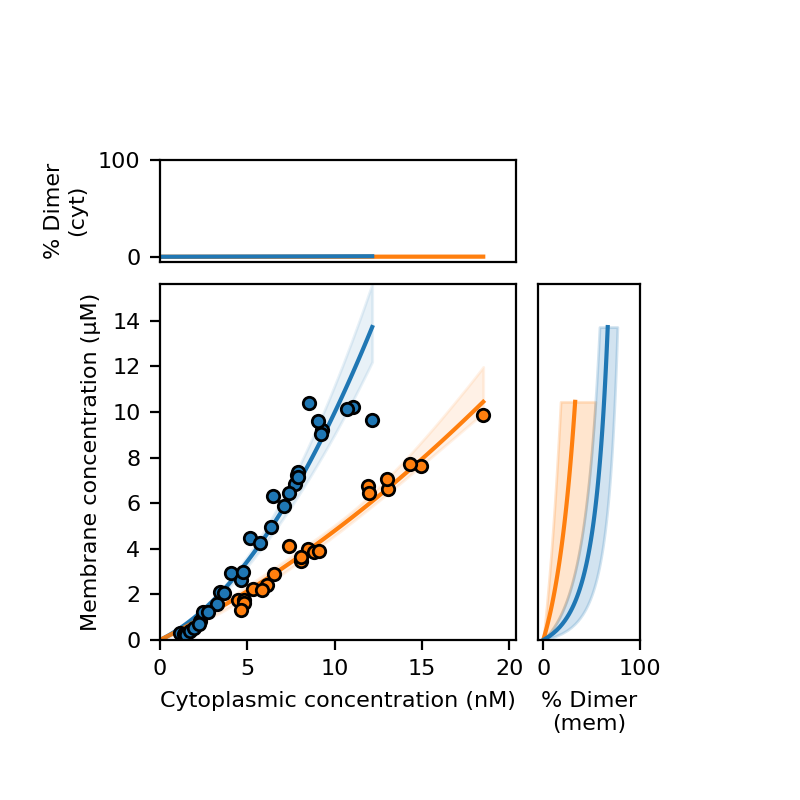

/Users/blandt/anaconda3/anaconda3/envs/membranequant/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/blandt/anaconda3/anaconda3/envs/membranequant/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator


In [16]:
def model_vs_data_with_dimerisation_fig():

    # Initiate figure
    fig = plt.figure(figsize=(4, 4))
    gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                          left=0.2, right=0.8, bottom=0.2, top=0.8,
                          wspace=0.1, hspace=0.1)
    ax = fig.add_subplot(gs[1, 0])
    ax_dimx = fig.add_subplot(gs[0, 0])
    ax_dimy = fig.add_subplot(gs[1, 1])
    
    # Axis limits (auto)
    xmin = min(np.min(x_wt), np.min(x_l109r)) * xc * 0
    xmax = max(np.max(x_wt), np.max(x_l109r)) * xc * 1.1
    ymin = min(np.min(y_wt), np.min(y_l109r)) * xm * 0
    ymax = max(np.max(y_wt), np.max(y_l109r)) * xm * 1.5
    
    # Scatter
    model_vs_data_fig(ax, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
    ax.set_xticklabels((ax.get_xticks() * 10 ** 9).astype(int))
    ax.set_yticklabels((ax.get_yticks() * 10 ** 6).astype(int))
    ax.set_xlabel('Cytoplasmic concentration (nM)', fontsize=8)
    ax.set_ylabel('Membrane concentration (μM)', fontsize=8)
    
    # Cytoplasmic dimer fraction
    dimer_fig(ax_dimx, data_wt=np.linspace(0.001 * max(x_wt), max(x_wt), 100) * xc, 
          data_l109r=np.linspace(0.001 * max(x_l109r), max(x_l109r), 100) * xc, xmin=xmin, xmax=xmax)
    ax_dimx.set_xticks([])
    ax_dimx.set_ylabel('% Dimer\n(cyt)', fontsize=8)
    
    # Membrane dimer fraction
    _wt_mem_max = model(np.r_[max(x_wt), 0], *p) * xm
    _l109r_mem_max = model(np.r_[0, max(x_l109r)], *p) * xm
    
    dimer_fig(ax_dimy, data_wt=np.linspace(0.001 * _wt_mem_max, _wt_mem_max, 100),
          data_l109r=np.linspace(0.001 * _l109r_mem_max, _l109r_mem_max, 100), vertical=True, 
             xmin=ymin, xmax=ymax)
    ax_dimy.set_yticks([])
    ax_dimy.set_xlabel('% Dimer\n(mem)', fontsize=8)
    fig.savefig('Figs/model_fit.png', dpi=600, transparent=True)
    
model_vs_data_with_dimerisation_fig()

### Create tables

#### Create table 1

In [111]:
def create_table1():
    # Energy strings
    wt_dimer_energy = '%.2f [%.2f, %.2f]' % (p_log[0], np.percentile(pb_log[:, 0], 97.5), 
                                         np.percentile(pb_log[:, 0], 2.5))

    l109r_dimer_energy = '%.2f [%.2f, %.2f]' % (p_log[1], np.percentile(pb_log[:, 1], 97.5), 
                                               np.percentile(pb_log[:, 1], 2.5))

    membrane_energy = '%.2f [%.2f, %.2f]' % (p_log[2], np.percentile(pb_log[:, 2], 97.5), 
                                            np.percentile(pb_log[:, 2], 2.5))

    wt_kd = '%.2f [%.2f, %.2f]' % (np.exp(-p_log[0]) * 10 ** 6,
                                np.exp(- np.percentile(pb_log[:, 0], 97.5)) * 10 ** 6, 
                                np.exp(- np.percentile(pb_log[:, 0], 2.5)) * 10 ** 6)

    l109r_kd = '%.2f [%.2f, %.2f]' % (np.exp(-p_log[1]) * 10 ** 6,
                                np.exp(- np.percentile(pb_log[:, 1], 97.5)) * 10 ** 6, 
                                np.exp(- np.percentile(pb_log[:, 1], 2.5)) * 10 ** 6)

    # Compile
    table_dict = {'Membrane energy (RT J mol⁻¹) [95% CI]': [membrane_energy, membrane_energy],
                'Dimer energy (RT J mol⁻¹) [95% CI]': [wt_dimer_energy, l109r_dimer_energy],
                'Dimerisation kD (μM) [95% CI]': [wt_kd, l109r_kd]}
    table = pd.DataFrame(df_dict, index=['PAR-2 (WT)', 'PAR-2 (L109R)']).transpose()
    return table

table1 = create_table1()
table1.to_csv('dimer_model_table1.csv')
table1

,PAR-2 (WT),PAR-2 (L109R)
Membrane energy (RT J mol⁻¹) [95% CI],"5.94 [6.11, 5.65]","5.94 [6.11, 5.65]"
Dimer energy (RT J mol⁻¹) [95% CI],"12.99 [13.83, 12.39]","11.16 [12.40, 10.15]"
Dimerisation kD (μM) [95% CI],"2.29 [0.98, 4.14]","14.25 [4.11, 39.24]"


#### Create table 2

In [117]:
def create_table2():
    
    # Concentration values
    cyt_wt_uni = np.mean(df[(df.Line == 'nwg201') & (df.Condition == 'wt')].Cyt.to_numpy()) * xc / x_wt_full
    mem_wt_uni = np.mean(df[(df.Line == 'nwg201') & (df.Condition == 'wt')].Mem_tot.to_numpy()) * xm / y_wt_full
    cyt_l109r_uni = np.mean(df[(df.Line == 'nwg369') & (df.Condition == 'wt')].Cyt.to_numpy()) * xc / x_wt_full
    mem_l109r_uni = np.mean(df[(df.Line == 'nwg369') & (df.Condition == 'wt')].Mem_tot.to_numpy()) * xm / y_wt_full

    cyt_wt_pol = np.mean(df[(df.Line == 'nwg325') & (df.Condition == 'wt')].Cyt.to_numpy()) * xc / x_wt_full
    mem_wt_pol = np.mean(df[(df.Line == 'nwg325') & (df.Condition == 'wt')].Mem_post.to_numpy()) * xm / y_wt_full
    cyt_l109r_pol = np.mean(df[(df.Line == 'nwg369') & (df.Condition == 'wt')].Cyt.to_numpy()) * xc / x_wt_full
    mem_l109r_pol = np.mean(df[(df.Line == 'nwg369') & (df.Condition == 'wt')].Mem_post.to_numpy()) * xm / y_wt_full
    
    # Concentration strings
    wt_uni_cyt_conc = '%.2f' % (cyt_wt_uni * 10 ** 9)
    wt_uni_mem_conc = '%.2f' % (mem_wt_uni * 10 ** 6)
    l109r_uni_cyt_conc = '%.2f' % (cyt_l109r_uni * 10 ** 9)
    l109r_uni_mem_conc = '%.2f' % (mem_l109r_uni * 10 ** 6)

    wt_pol_cyt_conc = '%.2f' % (cyt_wt_pol * 10 ** 9)
    wt_pol_mem_conc = '%.2f' % (mem_wt_pol * 10 ** 6)
    l109r_pol_cyt_conc = '%.2f' % (cyt_l109r_pol * 10 ** 9)
    l109r_pol_mem_conc = '%.2f' % (mem_l109r_pol * 10 ** 6)
    
    # Dimer strings
    wt_uni_cyt_dim = '%.2f [%.2f, %.2f]' % (100 * dimer_fraction(cyt_wt_uni, p_log[0]),
                            100 * dimer_fraction(cyt_wt_uni, np.percentile(pb_log[:, 0], 2.5)), 
                            100 * dimer_fraction(cyt_wt_uni, np.percentile(pb_log[:, 0], 97.5)))

    wt_uni_mem_dim = '%.2f [%.2f, %.2f]' % (100 * dimer_fraction(mem_wt_uni, p_log[0]),
                                100 * dimer_fraction(mem_wt_uni, np.percentile(pb_log[:, 0], 2.5)), 
                                100 * dimer_fraction(mem_wt_uni, np.percentile(pb_log[:, 0], 97.5)))

    l109r_uni_cyt_dim = '%.2f [%.2f, %.2f]' % (100 * dimer_fraction(cyt_l109r_uni, p_log[1]),
                                100 * dimer_fraction(cyt_l109r_uni, np.percentile(pb_log[:, 1], 2.5)), 
                                100 * dimer_fraction(cyt_l109r_uni, np.percentile(pb_log[:, 1], 97.5)))

    l109r_uni_mem_dim = '%.2f [%.2f, %.2f]' % (100 * dimer_fraction(mem_l109r_uni, p_log[1]),
                                100 * dimer_fraction(mem_l109r_uni, np.percentile(pb_log[:, 1], 2.5)), 
                                100 * dimer_fraction(mem_l109r_uni, np.percentile(pb_log[:, 1], 97.5)))

    wt_pol_cyt_dim = '%.2f [%.2f, %.2f]' % (100 * dimer_fraction(cyt_wt_pol, p_log[0]),
                                100 * dimer_fraction(cyt_wt_pol, np.percentile(pb_log[:, 0], 2.5)), 
                                100 * dimer_fraction(cyt_wt_pol, np.percentile(pb_log[:, 0], 97.5)))

    wt_pol_mem_dim = '%.2f [%.2f, %.2f]' % (100 * dimer_fraction(mem_wt_pol, p_log[0]),
                                100 * dimer_fraction(mem_wt_pol, np.percentile(pb_log[:, 0], 2.5)), 
                                100 * dimer_fraction(mem_wt_pol, np.percentile(pb_log[:, 0], 97.5)))

    l109r_pol_cyt_dim = '%.2f [%.2f, %.2f]' % (100 * dimer_fraction(cyt_l109r_pol, p_log[1]),
                                100 * dimer_fraction(cyt_l109r_pol, np.percentile(pb_log[:, 1], 2.5)), 
                                100 * dimer_fraction(cyt_l109r_pol, np.percentile(pb_log[:, 1], 97.5)))

    l109r_pol_mem_dim = '%.2f [%.2f, %.2f]' % (100 * dimer_fraction(mem_l109r_pol, p_log[1]),
                                100 * dimer_fraction(mem_l109r_pol, np.percentile(pb_log[:, 1], 2.5)), 
                                100 * dimer_fraction(mem_l109r_pol, np.percentile(pb_log[:, 1], 97.5)))
    
    # Compile
    table_dict = {'Cytoplasmic concentration (nM)': [wt_uni_cyt_conc, l109r_uni_cyt_conc],
           'Cytoplasmic dimer % [95% CI]': [wt_uni_cyt_dim, l109r_uni_cyt_dim],
           'Membrane concentration (μM)': [wt_uni_mem_conc, l109r_uni_mem_conc],
           'Membrane dimer % [95% CI]': [wt_uni_mem_dim, l109r_uni_mem_dim]}
    table = pd.DataFrame(table_dict, index=['PAR-2 (WT)', 'PAR-2 (L109R)']).transpose()
    return table

table2 = create_table2()
table2.to_csv('dimer_model_table2.csv')
table2

,PAR-2 (WT),PAR-2 (L109R)
Cytoplasmic concentration (nM),10.00,13.95
Cytoplasmic dimer % [95% CI],"0.43 [0.24, 1.00]","0.10 [0.04, 0.34]"
Membrane concentration (μM),9.76,7.45
Membrane dimer % [95% CI],"61.86 [52.70, 72.91]","27.48 [14.03, 48.35]"
